In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
%aimport classifier

import scipy
import numpy as np
import sys
import os
from skimage import io
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


classes = [
     'bighorn-sheep',
     'bison',
     'black-stork',
     'brown-bear',
     'bullfrog',
     'camel',
     'gazelle',
     'golden-retriever',
     'goldfish',
     'ladybug',
     'lion',
     'orangutan',
     'penguin',
     'persian-cat',
     'pig',
     'puma'
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def show_image(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [4]:
def get_N_images(N, class_name, root_folder):
    images = []
    for root, dir, files in os.walk(root_folder):
        if root.split(os.sep)[-1] == class_name:
            for i, file in enumerate(files):
                if file.endswith('.JPEG'):
                    images.append(plt.imread(os.path.join(root,file)))
                if i+1 == N:
                    return images

In [15]:
dataset_means = [123./255., 116./255.,  97./255.]
dataset_stds  = [ 54./255.,  53./255.,  52./255.]


transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(dataset_means, dataset_stds)
        ])

In [16]:
class AnimalDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform

        self.raw_data = []
        for i, cl in enumerate(self.classes):
            for root, directory, files in os.walk(os.path.join(root_dir, cl)):
                for file in files:
                    if '.JPEG' in file:
                        self.raw_data.append((os.path.join(root, file), i))

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        image_path, label = (self.raw_data[idx])
        image = io.imread(image_path)
        image = self.transform(image)
        label = torch.tensor([label], dtype=torch.long)
        return image, label

In [20]:
def get_dataloader(transform):
    """
    Returns dataloader for AnimalDataset given input transform, with batch size 1.
    """
    dataset = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=False)

In [25]:
def log_progress(curr_batch, batch_size, curr_epoch, total_epochs, dataloader):
    """
    Prints message logging progress through training.
    """
    progress = float(curr_batch + 1)/(float(len(dataloader.dataset)) / batch_size)
    log = "EPOCH [{}/{}].Progress: {} % ".format(
        curr_epoch + 1, total_epochs, round(progress * 100, 2))
    sys.stdout.write("\r" + log)
    sys.stdout.flush()

### Train Model

In [43]:
%aimport classifier

net = classifier.AnimalClassifierNet()
transform, batch_size, epochs, criterion, optimizer = classifier.get_classifier_settings(net)

for layer in net.children():
    print(layer)

Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(144, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [39]:
train_dataset = AnimalDataset(os.path.join('.', 'data', 'train'),classes, transform=transform[0])
val_dataset   = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform[1])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True)

In [40]:
%aimport classifier

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(epochs)
train_acc_history  = np.zeros(epochs)
val_loss_history   = np.zeros(epochs)
val_acc_history    = np.zeros(epochs)

start_time = datetime.now()

for epoch in range(epochs):
    
     # ============================ Training ==============================
    print("Training...")
    
    # Place network in training mode
    net.train()
    
    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(train_dataloader):
        # [inputs] and [labels] is one batch of images and their classes

        log_progress(batch_num, batch_size, epoch, epochs, train_dataloader)
        
        #  ***** Function call to classifier *****
        curr_loss, curr_correct, curr_images = \
            classifier.model_train(net, inputs, labels, criterion, optimizer)
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

    # Update statistics for epoch
    train_loss_history[epoch] = running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("\n Train Avg. Loss: [{}] Acc: {} on {} images\n".format(
          round(train_loss_history[epoch],4), train_acc_history[epoch], total_images) )
    
    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    net.eval()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(val_dataloader):
        
        # Propagate batch through network
        outputs  = net(inputs)
                                                 
        # Calculate loss
        loss     = criterion(outputs, labels.squeeze())
                                                 
        # Prediction is class with highest class score
        _, preds = torch.max(outputs, 1)
        
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.data.numpy().size
        
    # Update statistics for validation data
    val_loss_history[epoch] = running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))
    
print("Time Elapsed: {} seconds".format(
    (datetime.now() - start_time).total_seconds()))

Training...
EPOCH [1/10].Progress: 100.8 % 
 Train Avg. Loss: [0.0199] Acc: 0.182625 on 8000.0 images

Validating...
Val Avg. Loss: [0.0192] Acc: 0.29875 on 800.0 images

Training...
EPOCH [2/10].Progress: 100.8 % 
 Train Avg. Loss: [0.0169] Acc: 0.30675 on 8000.0 images

Validating...
Val Avg. Loss: [0.0167] Acc: 0.36125 on 800.0 images

Training...
EPOCH [3/10].Progress: 100.8 % 
 Train Avg. Loss: [0.0154] Acc: 0.372125 on 8000.0 images

Validating...
Val Avg. Loss: [0.0161] Acc: 0.425 on 800.0 images

Training...
EPOCH [4/10].Progress: 100.8 % 
 Train Avg. Loss: [0.0141] Acc: 0.424125 on 8000.0 images

Validating...
Val Avg. Loss: [0.0145] Acc: 0.4925 on 800.0 images

Training...
EPOCH [5/10].Progress: 100.8 % 
 Train Avg. Loss: [0.0134] Acc: 0.461375 on 8000.0 images

Validating...
Val Avg. Loss: [0.0144] Acc: 0.4925 on 800.0 images

Training...
EPOCH [6/10].Progress: 100.8 % 
 Train Avg. Loss: [0.0126] Acc: 0.49125 on 8000.0 images

Validating...
Val Avg. Loss: [0.014] Acc: 0.495 

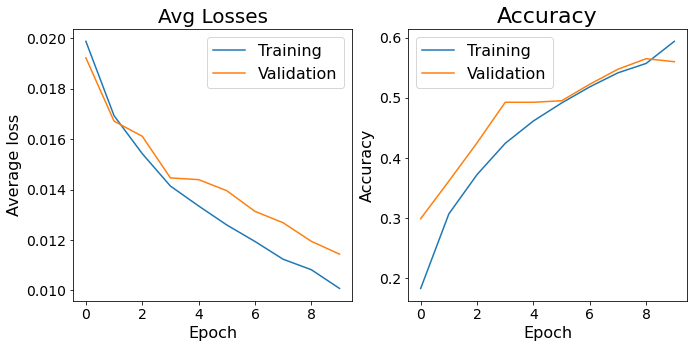

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

ax = axs[0]
ax.set_title("Avg Losses", fontsize=20)
ax.plot(train_loss_history, label="Training")
ax.plot(val_loss_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Average loss", fontsize=16)
ax.legend(loc="best",         fontsize=16)

ax = axs[1]
ax.set_title("Accuracy", fontsize=22)
ax.plot(train_acc_history, label="Training")
ax.plot(val_acc_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Accuracy",     fontsize=16)
ax.legend(loc="best",         fontsize=16)

In [42]:
torch.save(net.state_dict(), os.path.join('.','models','max8bb.pth'))

## Adversarial Images

In [36]:
%aimport classifier

# Load model
net          = classifier.AnimalClassifierNet()
weights_path = os.path.join('.', 'models', 'max4.pth')
net.load_state_dict(torch.load(weights_path, map_location="cpu"))

transform = transforms.Compose([
            transforms.ToTensor()
        ])
val_dataset    = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

criterion = nn.CrossEntropyLoss()
epsilon = 0.02

original_imgs      = []
original_preds     = []

adversarial_imgs   = []
adversarial_preds  = []
adversarial_noises = []


for i, (img, label) in enumerate(val_dataloader):
    
    img.requires_grad = True
    
    output = net(img)

    init_pred = output.max(1, keepdim=True)[1]
    
    if init_pred == label:
        # Image classified correctly; generate adversarial image
        perturbed_img, noise = classifier.get_adversarial(img, output, label[0], net, criterion, epsilon)
    
        adversarial_output = net(perturbed_img)
        adversarial_pred   = adversarial_output.max(1, keepdim=True)[1]

        original_imgs.append(to_pil(img.squeeze()))
        original_preds.append(init_pred)
        adversarial_imgs.append(to_pil(perturbed_img.squeeze()))
        adversarial_preds.append(adversarial_pred)
        adversarial_noises.append(to_pil(noise.squeeze()))
    


print("Out of total {} images generated, {} % of adversarial images misclassified".format(
    len(original_imgs),
    round((torch.sum(torch.Tensor(original_preds) != torch.Tensor(adversarial_preds)).item())
        / len(original_imgs) * 100., 4)))

Out of total 82 images generated, 90.2439 % of adversarial images misclassified


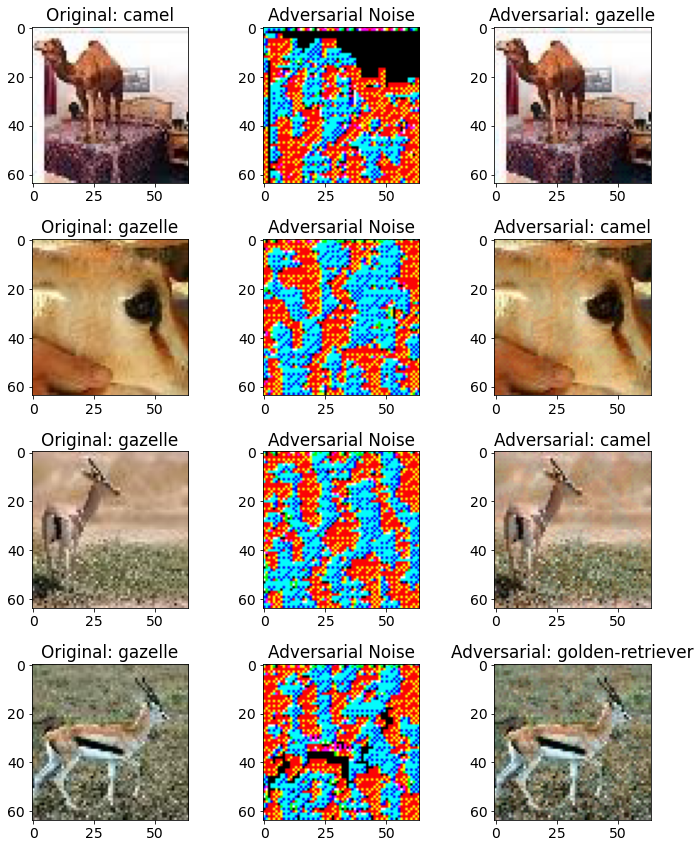

In [37]:
num_desired_adversarial = 4

fig, axs = plt.subplots(num_desired_adversarial, 3, figsize=(10,3*num_desired_adversarial))
matplotlib.rcParams.update({'font.size': 14})


for i in range(num_desired_adversarial):
    ax = axs[i,0]
    ax.set_title('Original: {}'.format(classes[original_preds[i]]))
    ax.imshow(original_imgs[i])
    
    ax = axs[i,1]
    ax.set_title('Adversarial Noise')
    ax.imshow(adversarial_noises[i])
    
    ax = axs[i,2]
    ax.set_title('Adversarial: {}'.format(classes[adversarial_preds[i]]))
    ax.imshow(adversarial_imgs[i])
    
plt.tight_layout()
plt.show()